## Fourier Neural Operators (FNO) in JAX

I follow the tutorial from [here](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_FNO_in_JAX.ipynb) to create a FNO in JAX.

In [40]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm

In [41]:
#!wget https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat

In [42]:
data = scipy.io.loadmat("burgers_data_R10.mat")
a, u = data["a"], data["u"]

In [43]:
a.shape

(2048, 8192)

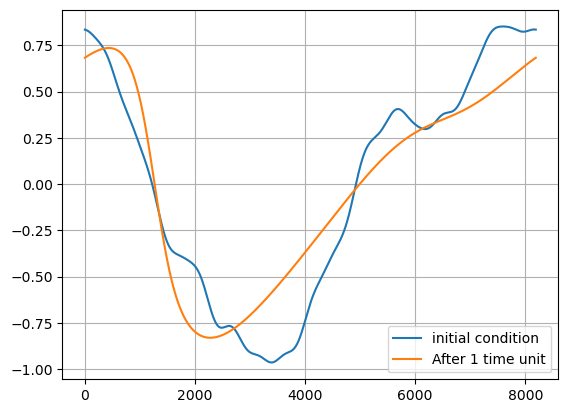

In [44]:
plt.plot(a[0], label="initial condition")
plt.plot(u[0], label="After 1 time unit")
plt.legend()
plt.grid()

In [45]:
# Add channel dimension
a = a[:, jnp.newaxis, :]
u = u[:, jnp.newaxis, :]

In [46]:
# Mesh is from 0 to 2 pi
mesh = jnp.linspace(0, 2 * jnp.pi, u.shape[-1])

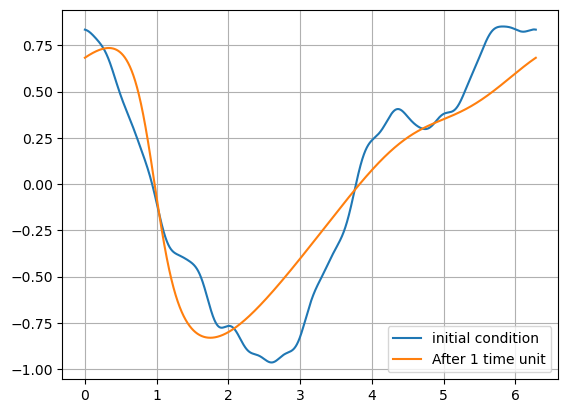

In [47]:
plt.plot(mesh, a[0, 0], label="initial condition")
plt.plot(mesh, u[0, 0], label="After 1 time unit")
plt.legend()
plt.grid()

In [48]:
mesh_shape_corrected = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, :], u.shape[0], axis=0)
a_with_mesh = jnp.concatenate((a, mesh_shape_corrected), axis=1)
a_with_mesh.shape

(2048, 2, 8192)

In [49]:
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]  #Frage: wieso ist mesh mit in Trainingsdaten? - wenn Trainingsdaten an verschiedenen
#Orten sind würde ichs verstehen, weil je nachdem wo man misst ist dann ja Vorhersage vllt anders, auch wenn bspw Input-Funktion überall gleich , sich also durch andere Messorte nicht verändert,aber hier sind Messorte doch immer gleich?
train_y, test_y = u[:1000], u[1000:1200]

In [50]:
class SpectralConv1d(eqx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            *,
            key,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        scale = 1.0 / (in_channels * out_channels)

        real_key, imag_key = jax.random.split(key)
        self.real_weights = jax.random.uniform(
            real_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )
        self.imag_weights = jax.random.uniform(
            imag_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )

    #im Fourierraum entspricht die Faltung einfach einer Multiplikation mit einem Filter, sprich wir multiplizieren einfach mit den Filterkoeffizienten (ohne Summe darüner natürlich)
    #analog wie bei CNNs macht man dann Summe über input channels (oder halt andere Aggregation evtl.) und dann für jeden output channel andere Koeffizienten und deswegen 
    #ist die output dim dann o,M     
    def complex_mult1d(
            self,
            x_hat,
            w,
    ):
        return jnp.einsum("iM,ioM->oM", x_hat, w)  #Summe über i, also die input channels
    
    def __call__(
            self,
            x,
    ):
        channels, spatial_points = x.shape

        # shape of x_hat is (in_channels, spatial_points//2+1)
        x_hat = jnp.fft.rfft(x)
        # shape of x_hat_under_modes is (in_channels, self.modes)
        x_hat_under_modes = x_hat[:, :self.modes]
        weights = self.real_weights + 1j * self.imag_weights
        # shape of out_hat_under_modes is (out_channels, self.modes)
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)

        # shape of out_hat is (out_channels, spatial_points//2+1)
        out_hat = jnp.zeros(
            (self.out_channels, x_hat.shape[-1]),
            dtype=x_hat.dtype
        )
        out_hat = out_hat.at[:, :self.modes].set(out_hat_under_modes)

        out = jnp.fft.irfft(out_hat, n=spatial_points)

        return out



In [52]:
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass_conv: eqx.nn.Conv1d
    activation: Callable

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            activation,
            *,
            key,
    ):
        spectral_conv_key, bypass_conv_key = jax.random.split(key)
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            modes,
            key=spectral_conv_key,
        )
        #vllt fragen: in Paper steht eig, dass zusätzlich einfach affine Trafo und hier jetzt convolution 
        #convolution kann ja auch als Matrixmultiplikation gesehen werden und deswegen ist das dann einfach auch affine trafo (halt special case)?
        self.bypass_conv = eqx.nn.Conv1d(
            in_channels,
            out_channels,
            1,  # Kernel size is one
            key=bypass_conv_key,
        )
        self.activation = activation

    def __call__(
            self,
            x,
    ):
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )

In [53]:
class FNO1d(eqx.Module):
    lifting: eqx.nn.Conv1d
    fno_blocks: List[FNOBlock1d]
    projection: eqx.nn.Conv1d

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            width,
            activation,
            n_blocks = 4,
            *,
            key,
    ):
        key, lifting_key = jax.random.split(key)
        #lifting erhöht channel dim aber nicht spatial dim
        self.lifting = eqx.nn.Conv1d(
            in_channels,
            width,
            1,
            key=lifting_key,
        )

        self.fno_blocks = []
        for i in range(n_blocks):
            key, subkey = jax.random.split(key)  #bedeutet das, jeder Block wird gleich initialisiert, weil immer gleicher key?
            self.fno_blocks.append(FNOBlock1d(
                width,
                width,
                modes,
                activation,
                key=subkey,
            ))
        #projection umgekehrt zu lifting
        key, projection_key = jax.random.split(key)
        self.projection = eqx.nn.Conv1d(
            width,
            out_channels,
            1,
            key=projection_key,
        )
    def __call__(
            self,
            x,
    ):
        x = self.lifting(x)

        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)

        return x

In [54]:
fno = FNO1d(
    2,
    1,
    16,
    64,
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
)

In [55]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [56]:
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))

@eqx.filter_jit   #was bedeutet das?
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x[..., ::32], test_y[..., ::32])
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(200)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x[..., ::32],   #wenn ich Analoges machen möchte hier aufpasse, nimmt nur jedes 32 Element, das will ich höchstwahrscheinlich nicht
        train_y[..., ::32],
        batch_size=100,
    ):
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

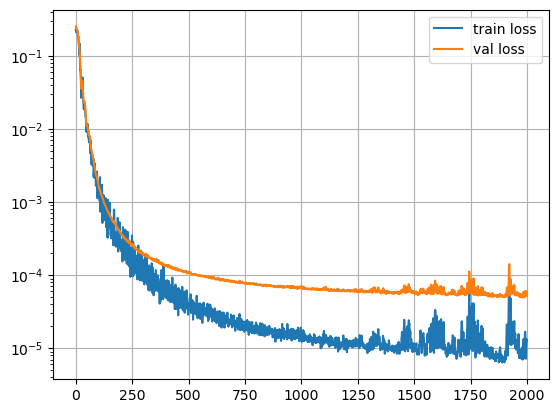

In [57]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

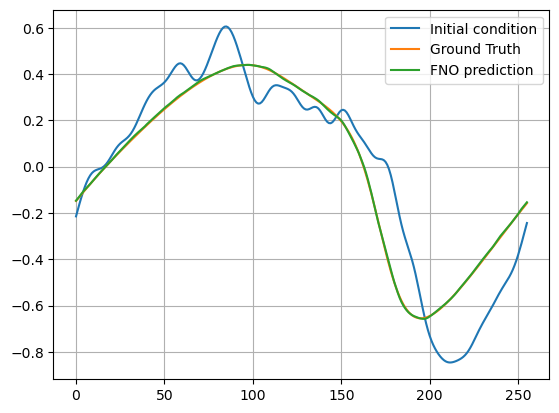

In [61]:
plt.plot(test_x[1, 0, ::32], label="Initial condition")
plt.plot(test_y[1, 0, ::32], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::32])[0], label="FNO prediction")
plt.legend()
plt.grid()

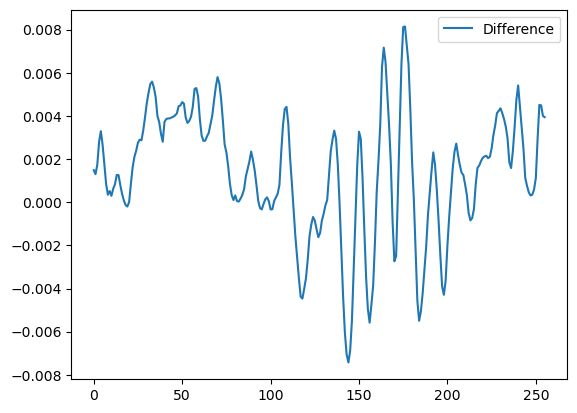

In [62]:
plt.plot(fno(test_x[1, :, ::32])[0] - test_y[1, 0, ::32], label="Difference")
plt.legend()
plt.show()

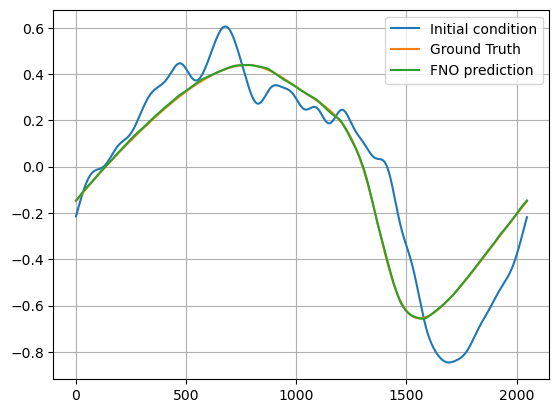

In [63]:
# Zero-Shot superresolution -> wurde ja nur auf Resolution mit jedem 32. Pixel trainiert
plt.plot(test_x[1, 0, ::4], label="Initial condition")
plt.plot(test_y[1, 0, ::4], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::4])[0], label="FNO prediction")
plt.legend()
plt.grid()

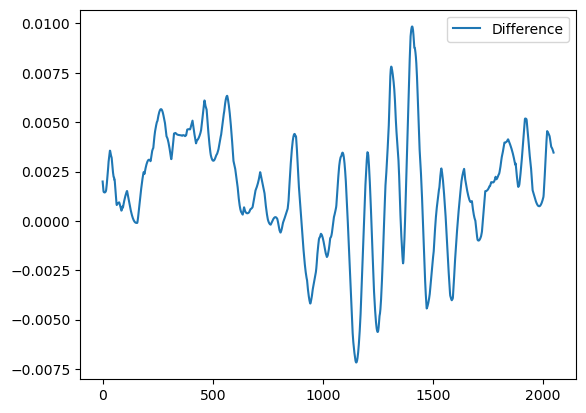

In [64]:
plt.plot(fno(test_x[1, :, ::4])[0] - test_y[1, 0, ::4], label="Difference")
plt.legend()
plt.show()